## Domain Adaptation Run

In this notebook, we run domain adaption (DA) in addition to mean-variance estimation (MVE). This is MVE-UDA. All notebooks are identical, except for 2 changes, as specified below.

**NOTE:**  
SEED - Seed will change between Runs (Run A, B, C, D, E), but is consistent across MVE-only and MVE-UDA.  
DA Weight - DA Weight is 1.4 for MVE-UDA runs. DA Weight is 0.0 for MVE-only runs.

In [ ]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

### Set Seed

Seed is set according to run index. Specifically,
* Run A: Seed 56
* Run B: Seed 11
* Run C: Seed 31
* Run D: Seed 6
* Run E: Seed 63

In [2]:
#fix seed
seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

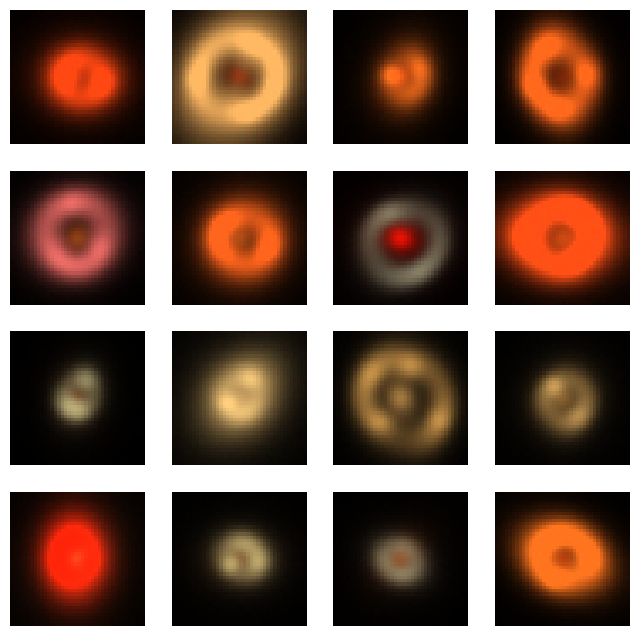

In [4]:
# Visualize source data
visualize_data(source_data)

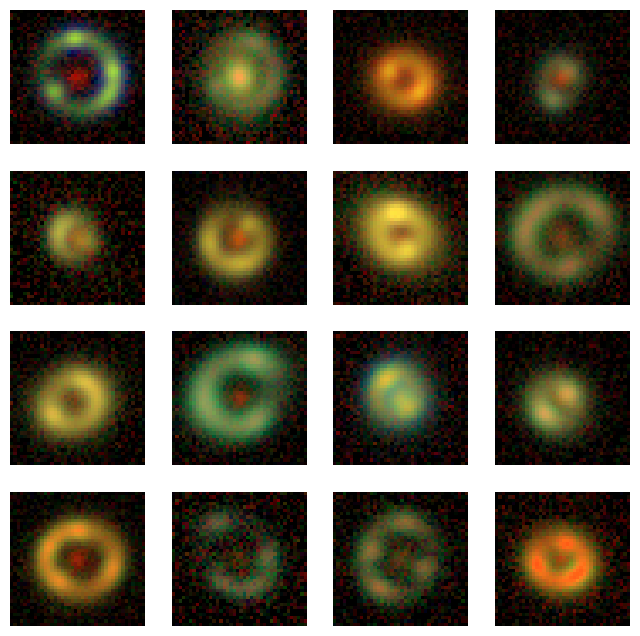

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

DA Weight is set according to MVE-Only or MVE-UDA run. Specifically,  
* MVE-UDA: DA Weight = constant 1.4
* MVE-only: DA Weight = constant 0.0, i.e. NO DA Loss

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    # if epoch < evolv_epoch:
    #     da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    # else:
    #     da_weight = final_wt_da
    return 1.4

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    # if epoch < evolv_epoch:
    #     beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    # else:
    #     beta_val = beta_final
    return 0.5

# Initialize hyperparameters
n_epoch = 150


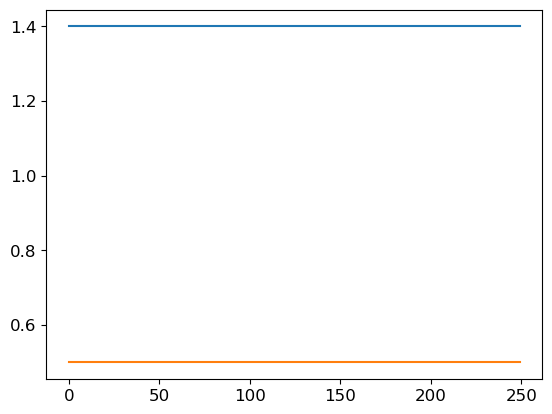

In [7]:
# Visualize the evolution of DA Weight and beta
s = np.arange(250)
plt.plot(s, [da_weight_function(i) for i in s])
plt.plot(s, [beta_function(i) for i in s])

### Initialize the Model

Model architecture (MVEv3) is identical to architecture in the paper and summarized below.

In [8]:
# Initialize model
model = NeuralNetworkMVEv3(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.AdamW(model.parameters())

In [9]:
from torchsummary import summary
summary(model, (3, 40, 40))

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 40, 40]             224
              ReLU-2            [-1, 8, 40, 40]               0
       BatchNorm2d-3            [-1, 8, 40, 40]              16
         MaxPool2d-4            [-1, 8, 20, 20]               0
            Conv2d-5           [-1, 16, 20, 20]           1,168
              ReLU-6           [-1, 16, 20, 20]               0
       BatchNorm2d-7           [-1, 16, 20, 20]              32
         MaxPool2d-8           [-1, 16, 10, 10]               0
            Conv2d-9           [-1, 32, 10, 10]           4,640
             ReLU-10           [-1, 32, 10, 10]               0
      BatchNorm2d-11           [-1, 32, 10, 10]              64
        MaxPool2d-12             [-1, 32, 5, 5]               0
           Linear-13                  [-1, 128]         102,528
          Sigmoid-14                  [

### Initialize Model State

If loading a paused run, enter a `load_mod_name`. If not, leave None, and the state will be initialized automatically.  
`save_mod_name` describes what root name models will be saved under during training.

In [10]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None 
stats, model, optimizer, best_target_R2, best_mve_loss, best_nll_loss, best_snll_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/RunA"

## Train

Beginning Training...
Generating Isomap...


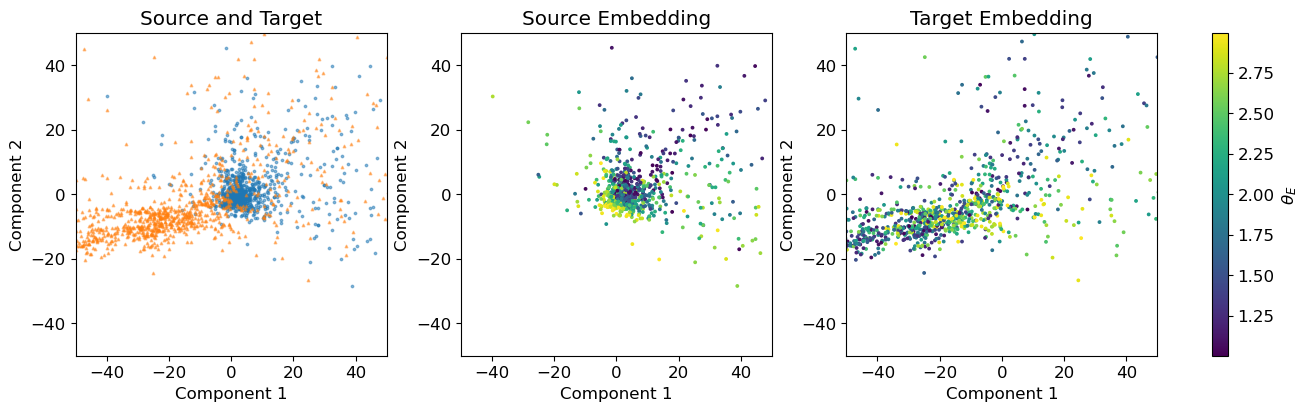

Saving Model... Done.

Epoch 0: 33.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0350
	Train Regression Loss: : 0.1467
	Train Mve Loss: : -0.1505
	Train R2 Score: : 0.5523
 Validation Statistics:
	Val Source Regression Loss: : 0.0220
	Val Target Regression Loss: : 0.0240
	Val Source R2 Score: : 0.9323
	Val Target R2 Score: : 0.9286
	Val Source Mve Loss: : -0.3336
	Val Target Mve Loss: : -0.3311
	Val Source Nll Loss: : -0.7653
	Val Target Nll Loss: : -0.7592
Saving Model... Done.
Saving Model MVE... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 1: 31.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0362
	Train Regression Loss: : 0.0209
	Train Mve Loss: : -0.1946
	Train R2 Score: : 0.9366
 Validation Statistics:
	Val Source Regression Loss: : 0.0156
	Val Target Regression Loss: : 0.0171
	Val Source R2 Score: : 0.9520
	Val Target R2 Score: : 0.9491
	Val Source Mve Loss: : -0.2517
	Val Target Mve Loss: : -0.24

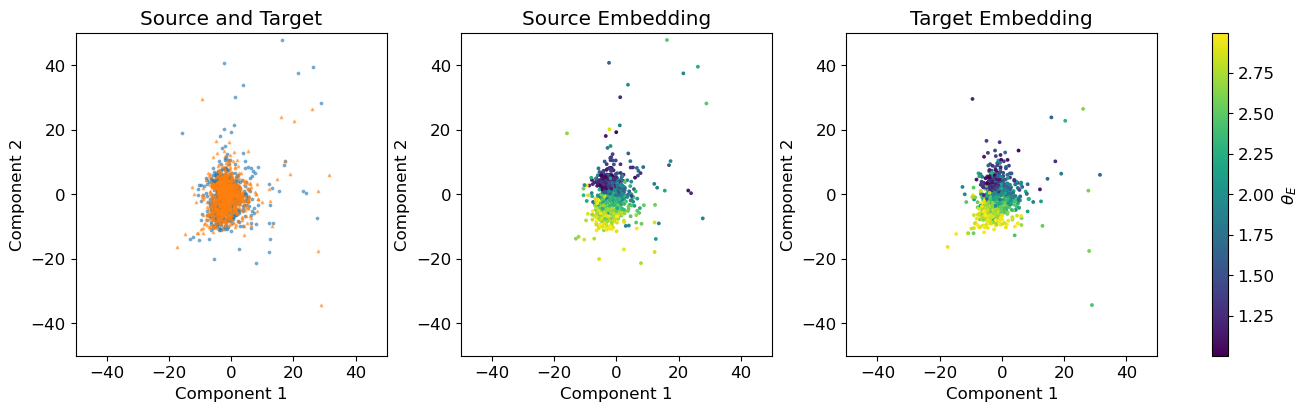

Saving Model... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 20: 35.22s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0145
	Train Regression Loss: : 0.0046
	Train Mve Loss: : -0.1680
	Train R2 Score: : 0.9861
 Validation Statistics:
	Val Source Regression Loss: : 0.0043
	Val Target Regression Loss: : 0.0072
	Val Source R2 Score: : 0.9868
	Val Target R2 Score: : 0.9783
	Val Source Mve Loss: : -0.1574
	Val Target Mve Loss: : -0.1462
	Val Source Nll Loss: : -2.2472
	Val Target Nll Loss: : -2.0648
Saving Model... Done.
Saving Model NLL... Done.
Saving Model SNLL... Done.

Epoch 21: 34.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0134
	Train Regression Loss: : 0.0039
	Train Mve Loss: : -0.1485
	Train R2 Score: : 0.9881
 Validation Statistics:
	Val Source Regression Loss: : 0.0037
	Val Target Regression Loss: : 0.0050
	Val Source R2 Score: : 0.9888
	Val Target R2 Score: : 0.9853
	Val Source Mve Loss: : -0.1348


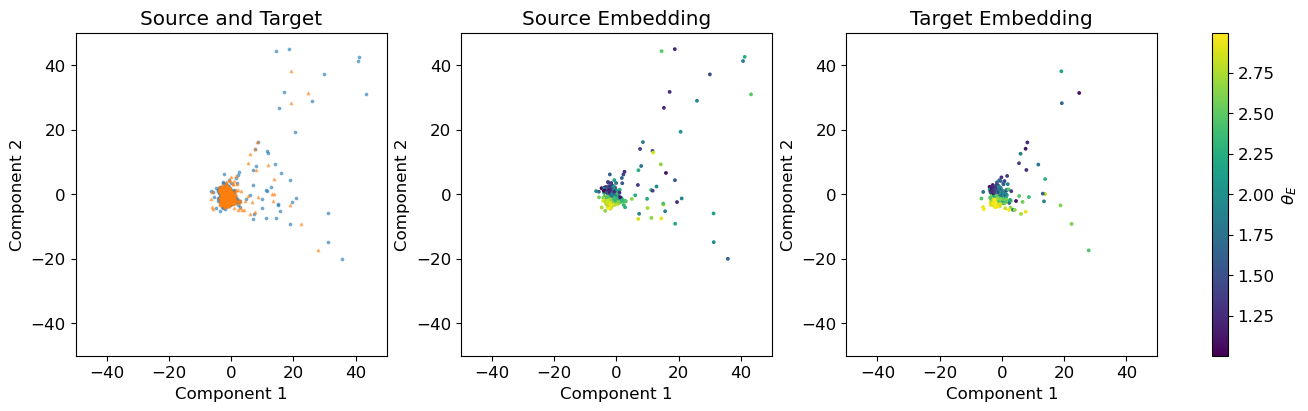

Saving Model... Done.
Saving Model... Done.

Epoch 40: 33.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0079
	Train Regression Loss: : 0.0038
	Train Mve Loss: : -0.3119
	Train R2 Score: : 0.9884
 Validation Statistics:
	Val Source Regression Loss: : 0.0042
	Val Target Regression Loss: : 0.0056
	Val Source R2 Score: : 0.9870
	Val Target R2 Score: : 0.9832
	Val Source Mve Loss: : -0.2131
	Val Target Mve Loss: : -0.2065
	Val Source Nll Loss: : -2.0829
	Val Target Nll Loss: : -2.0139

Epoch 41: 33.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0072
	Train Regression Loss: : 0.0030
	Train Mve Loss: : -0.1903
	Train R2 Score: : 0.9909
 Validation Statistics:
	Val Source Regression Loss: : 0.0024
	Val Target Regression Loss: : 0.0047
	Val Source R2 Score: : 0.9926
	Val Target R2 Score: : 0.9849
	Val Source Mve Loss: : -0.2738
	Val Target Mve Loss: : -0.2683
	Val Source Nll Loss: : -1.8612
	Val Target Nll Loss: : -1.8292

Epoch 42:

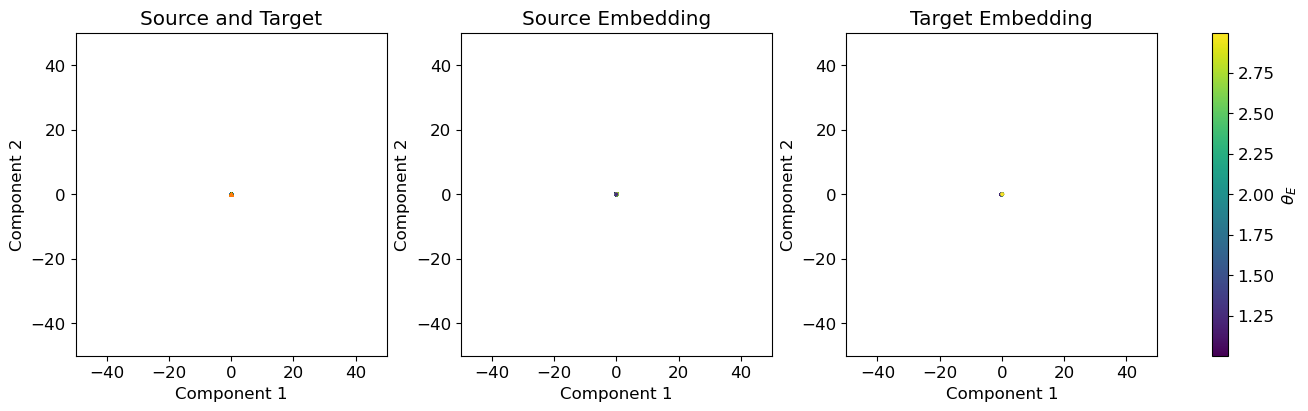

Saving Model... Done.

Epoch 60: 33.57s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0429
	Train Regression Loss: : 0.0050
	Train Mve Loss: : -0.1531
	Train R2 Score: : 0.9849
 Validation Statistics:
	Val Source Regression Loss: : 0.0040
	Val Target Regression Loss: : 0.0048
	Val Source R2 Score: : 0.9877
	Val Target R2 Score: : 0.9857
	Val Source Mve Loss: : -0.1755
	Val Target Mve Loss: : -0.1711
	Val Source Nll Loss: : -2.2356
	Val Target Nll Loss: : -2.1729

Epoch 61: 34.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0433
	Train Regression Loss: : 0.0054
	Train Mve Loss: : -0.1906
	Train R2 Score: : 0.9835
 Validation Statistics:
	Val Source Regression Loss: : 0.0051
	Val Target Regression Loss: : 0.0057
	Val Source R2 Score: : 0.9846
	Val Target R2 Score: : 0.9831
	Val Source Mve Loss: : -0.1332
	Val Target Mve Loss: : -0.1293
	Val Source Nll Loss: : -2.1588
	Val Target Nll Loss: : -2.0904

Epoch 62: 33.63s
--------------

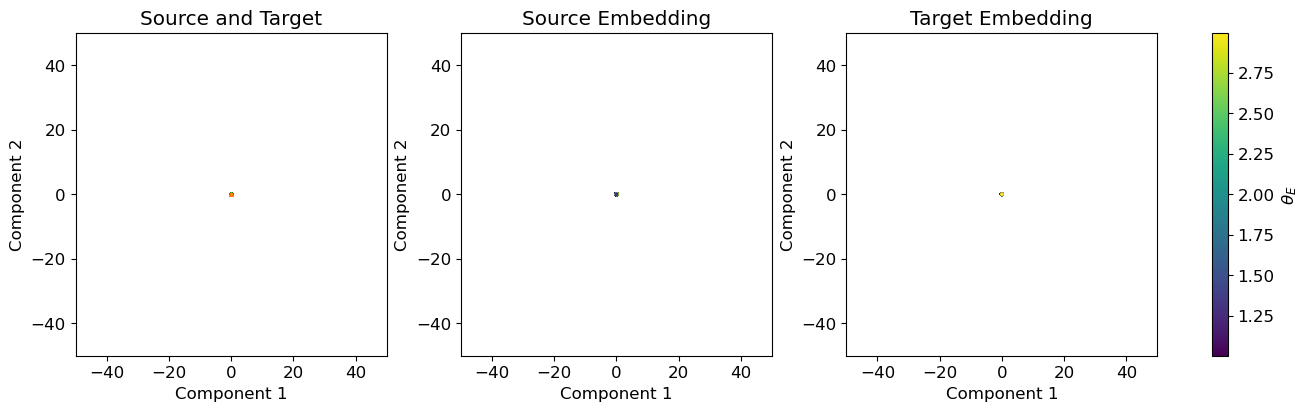

Saving Model... Done.

Epoch 80: 41.46s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0431
	Train Regression Loss: : 0.0049
	Train Mve Loss: : -0.1597
	Train R2 Score: : 0.9850
 Validation Statistics:
	Val Source Regression Loss: : 0.0058
	Val Target Regression Loss: : 0.0071
	Val Source R2 Score: : 0.9822
	Val Target R2 Score: : 0.9789
	Val Source Mve Loss: : -0.1250
	Val Target Mve Loss: : -0.1150
	Val Source Nll Loss: : -2.0535
	Val Target Nll Loss: : -1.8871

Epoch 81: 41.23s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0428
	Train Regression Loss: : 0.0213
	Train Mve Loss: : -0.2669
	Train R2 Score: : 0.9349
 Validation Statistics:
	Val Source Regression Loss: : 0.0102
	Val Target Regression Loss: : 0.0115
	Val Source R2 Score: : 0.9681
	Val Target R2 Score: : 0.9658
	Val Source Mve Loss: : -0.3487
	Val Target Mve Loss: : -0.3466
	Val Source Nll Loss: : -1.0841
	Val Target Nll Loss: : -1.0783

Epoch 82: 43.87s
--------------

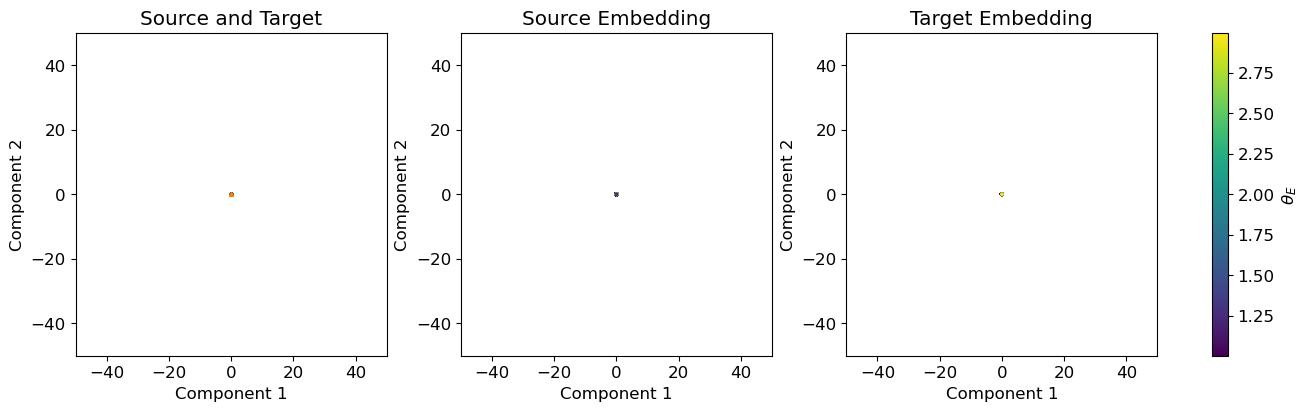

Saving Model... Done.

Epoch 100: 44.72s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0428
	Train Regression Loss: : 0.0093
	Train Mve Loss: : -0.1835
	Train R2 Score: : 0.9717
 Validation Statistics:
	Val Source Regression Loss: : 0.0090
	Val Target Regression Loss: : 0.0111
	Val Source R2 Score: : 0.9726
	Val Target R2 Score: : 0.9668
	Val Source Mve Loss: : -0.1439
	Val Target Mve Loss: : -0.1310
	Val Source Nll Loss: : -1.8365
	Val Target Nll Loss: : -1.6806

Epoch 101: 44.31s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0440
	Train Regression Loss: : 0.0083
	Train Mve Loss: : -0.1781
	Train R2 Score: : 0.9748
 Validation Statistics:
	Val Source Regression Loss: : 0.0141
	Val Target Regression Loss: : 0.0160
	Val Source R2 Score: : 0.9569
	Val Target R2 Score: : 0.9524
	Val Source Mve Loss: : -0.1228
	Val Target Mve Loss: : -0.1120
	Val Source Nll Loss: : -1.5016
	Val Target Nll Loss: : -1.3768

Epoch 102: 46.21s
-----------

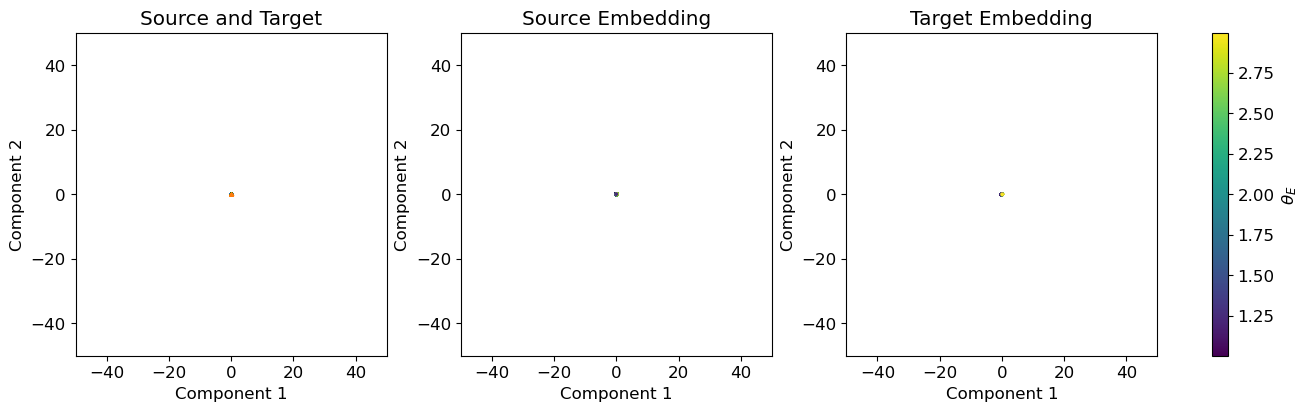

Saving Model... Done.

Epoch 120: 51.10s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0432
	Train Regression Loss: : 0.0069
	Train Mve Loss: : -0.1688
	Train R2 Score: : 0.9791
 Validation Statistics:
	Val Source Regression Loss: : 0.0059
	Val Target Regression Loss: : 0.0081
	Val Source R2 Score: : 0.9821
	Val Target R2 Score: : 0.9761
	Val Source Mve Loss: : -0.1986
	Val Target Mve Loss: : -0.1876
	Val Source Nll Loss: : -2.0181
	Val Target Nll Loss: : -1.9057

Epoch 121: 41.19s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0435
	Train Regression Loss: : 0.0070
	Train Mve Loss: : -0.1804
	Train R2 Score: : 0.9787
 Validation Statistics:
	Val Source Regression Loss: : 0.0062
	Val Target Regression Loss: : 0.0085
	Val Source R2 Score: : 0.9811
	Val Target R2 Score: : 0.9747
	Val Source Mve Loss: : -0.1703
	Val Target Mve Loss: : -0.1571
	Val Source Nll Loss: : -2.0484
	Val Target Nll Loss: : -1.8956

Epoch 122: 38.24s
-----------

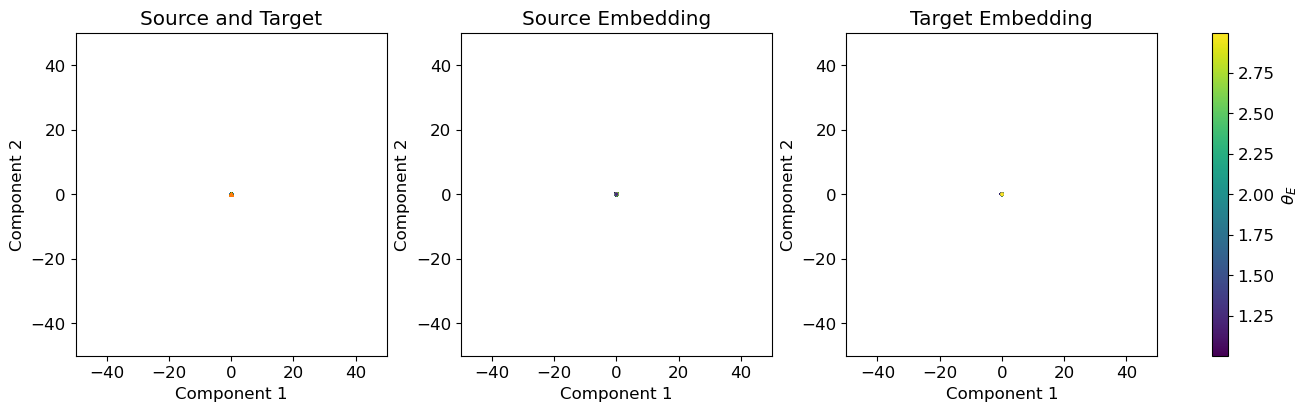

Saving Model... Done.

Epoch 140: 44.25s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0443
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.3253
	Train R2 Score: : 0.9631
 Validation Statistics:
	Val Source Regression Loss: : 0.0105
	Val Target Regression Loss: : 0.0117
	Val Source R2 Score: : 0.9676
	Val Target R2 Score: : 0.9650
	Val Source Mve Loss: : -0.3085
	Val Target Mve Loss: : -0.3056
	Val Source Nll Loss: : -1.4065
	Val Target Nll Loss: : -1.3933

Epoch 141: 41.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.0422
	Train Regression Loss: : 0.0094
	Train Mve Loss: : -0.2486
	Train R2 Score: : 0.9714
 Validation Statistics:
	Val Source Regression Loss: : 0.0075
	Val Target Regression Loss: : 0.0093
	Val Source R2 Score: : 0.9770
	Val Target R2 Score: : 0.9725
	Val Source Mve Loss: : -0.1869
	Val Target Mve Loss: : -0.1773
	Val Source Nll Loss: : -1.8910
	Val Target Nll Loss: : -1.7870

Epoch 142: 43.19s
-----------

In [11]:
print("Beginning Training...")

for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)
            
            print("Saving Model...", end = ' ')
            save_model(save_mod_name + "_{}".format(curr_epoch), model, optimizer, stats)
            print("Done.")

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_nll_loss'][-1] < best_nll_loss):
                print("Saving Model NLL...", end = ' ')
                nll_name = save_mod_name + "_nll"
                save_model(nll_name, model, optimizer, stats)
                best_nll_loss = stats['val_target_nll_loss'][-1]
                print("Done.")

            # Save and overwrite model every best target MVE Loss
            if (stats['val_source_nll_loss'][-1] < best_snll_loss):
                print("Saving Model SNLL...", end = ' ')
                snll_name = save_mod_name + "_snll"
                save_model(snll_name, model, optimizer, stats)
                best_snll_loss = stats['val_source_nll_loss'][-1]
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)


        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        stats['val_source_nll_loss'].append(vals_validate[6])
        stats['val_target_nll_loss'].append(vals_validate[7])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        #stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [12]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

You can visualize the results below. We recommend using the `VisualizeModel.ipynb` notebook for more detailed visualization.

In [ ]:
# Loads a model for plotting/viz

viz_mod_name = save_mod_name #"models/papermve_v3_aug22_1315_C_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

In [ ]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

In [ ]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [ ]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-1, 1)

In [ ]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['val_source_nll_loss'], label = "Source Val NLL Loss")
plt.plot(eps, stats['val_target_nll_loss'], label = "Target Val NLL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 1)

In [ ]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [ ]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.0))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | NLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [ ]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [ ]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

In [ ]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()